# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [15]:
data_dir = './data'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

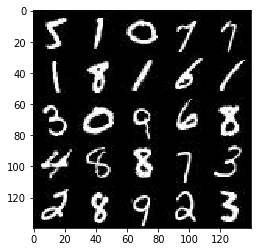

In [16]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

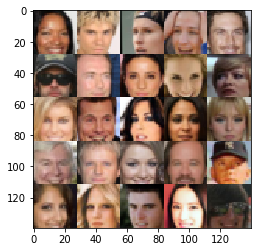

In [17]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [18]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [19]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='lr')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [20]:
def myconv2d(x, size):
    return tf.layers.conv2d(x, size, 5, strides=2, padding='same',
                            kernel_initializer=tf.contrib.layers.xavier_initializer())

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha=0.2
    training = not reuse
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = myconv2d(images, 64)
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = myconv2d(relu1, 128)
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = myconv2d(relu2, 256)
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1, kernel_initializer=tf.contrib.layers.xavier_initializer())
        out = tf.sigmoid(logits)
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [21]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    reuse=not is_train
    alpha=0.2
    quantum=7
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, quantum*quantum*512, kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, quantum, quantum, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same', 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same', 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())   
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same', 
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [22]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_model_real* np.random.uniform(0.7, 1.2))))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [23]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    deps = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    d_dep = [dep for dep in deps if dep.name.startswith("discriminator")]
    g_dep = [dep for dep in deps if dep.name.startswith("generator")]
    
    with tf.control_dependencies(d_dep):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    with tf.control_dependencies(g_dep):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [24]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [25]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    ## Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])            
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    print_every = 20
    show_every = 100
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                ## Train Model
                steps += 1
                
                # batch images mapped to -1, 1
                batch_images = batch_images*2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z, input_real: batch_images})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

            train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
            train_loss_g = g_loss.eval({input_z: batch_z, input_real: batch_images})
            print("Final of Epoch {}/{}...".format(epoch_i+1, epoch_count),
                  "Discriminator Loss: {:.4f}...".format(train_loss_d),
                  "Generator Loss: {:.4f}".format(train_loss_g))
            show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.3623... Generator Loss: 0.1699
Epoch 1/2... Discriminator Loss: 1.7909... Generator Loss: 2.1367
Epoch 1/2... Discriminator Loss: 1.8282... Generator Loss: 1.0698
Epoch 1/2... Discriminator Loss: 1.5078... Generator Loss: 0.9173
Epoch 1/2... Discriminator Loss: 1.5158... Generator Loss: 1.0452


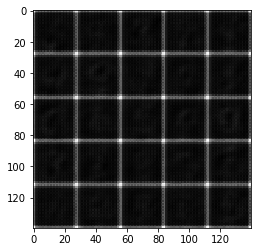

Epoch 1/2... Discriminator Loss: 1.3420... Generator Loss: 1.0137
Epoch 1/2... Discriminator Loss: 1.3528... Generator Loss: 1.1321
Epoch 1/2... Discriminator Loss: 1.2031... Generator Loss: 0.7764
Epoch 1/2... Discriminator Loss: 1.2777... Generator Loss: 1.1953
Epoch 1/2... Discriminator Loss: 1.1881... Generator Loss: 1.5322


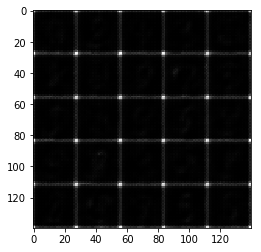

Epoch 1/2... Discriminator Loss: 1.1749... Generator Loss: 1.1987
Epoch 1/2... Discriminator Loss: 0.9634... Generator Loss: 1.1516
Epoch 1/2... Discriminator Loss: 1.0810... Generator Loss: 1.3234
Epoch 1/2... Discriminator Loss: 1.0352... Generator Loss: 0.7192
Epoch 1/2... Discriminator Loss: 1.6566... Generator Loss: 0.2610


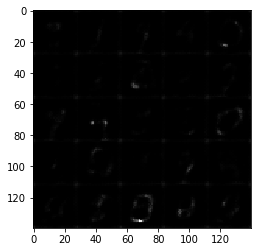

Epoch 1/2... Discriminator Loss: 1.6144... Generator Loss: 0.2843
Epoch 1/2... Discriminator Loss: 1.3638... Generator Loss: 0.3739
Epoch 1/2... Discriminator Loss: 1.4636... Generator Loss: 0.3867
Epoch 1/2... Discriminator Loss: 1.5322... Generator Loss: 0.3173
Epoch 1/2... Discriminator Loss: 1.6964... Generator Loss: 0.2587


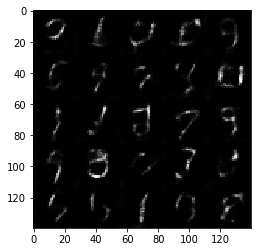

Epoch 1/2... Discriminator Loss: 1.5515... Generator Loss: 0.3181
Epoch 1/2... Discriminator Loss: 1.5107... Generator Loss: 0.3443
Epoch 1/2... Discriminator Loss: 1.2484... Generator Loss: 0.5185
Epoch 1/2... Discriminator Loss: 0.9316... Generator Loss: 1.3900
Epoch 1/2... Discriminator Loss: 1.1916... Generator Loss: 1.2542


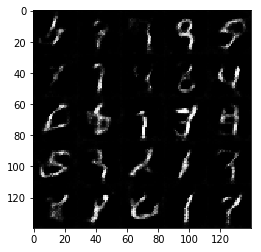

Epoch 1/2... Discriminator Loss: 1.1935... Generator Loss: 0.4956
Epoch 1/2... Discriminator Loss: 1.1795... Generator Loss: 0.5384
Epoch 1/2... Discriminator Loss: 1.3273... Generator Loss: 0.4314
Epoch 1/2... Discriminator Loss: 1.5180... Generator Loss: 0.3418
Epoch 1/2... Discriminator Loss: 1.3811... Generator Loss: 0.3924


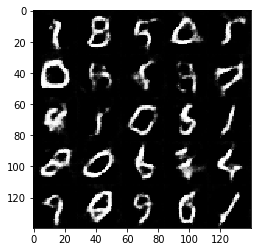

Epoch 1/2... Discriminator Loss: 1.1911... Generator Loss: 0.5178
Epoch 1/2... Discriminator Loss: 1.2861... Generator Loss: 0.4591
Epoch 1/2... Discriminator Loss: 1.1084... Generator Loss: 0.6604
Epoch 1/2... Discriminator Loss: 1.0727... Generator Loss: 1.4535
Epoch 1/2... Discriminator Loss: 1.0166... Generator Loss: 1.0552


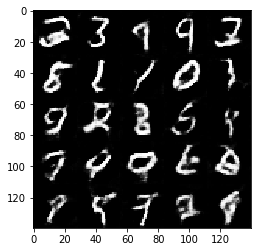

Epoch 1/2... Discriminator Loss: 1.0751... Generator Loss: 1.3292
Epoch 1/2... Discriminator Loss: 1.1954... Generator Loss: 0.5473
Epoch 1/2... Discriminator Loss: 0.8705... Generator Loss: 0.9758
Epoch 1/2... Discriminator Loss: 1.0395... Generator Loss: 0.6545
Epoch 1/2... Discriminator Loss: 1.3108... Generator Loss: 0.4329


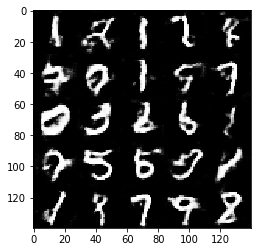

Epoch 1/2... Discriminator Loss: 1.2127... Generator Loss: 1.3814
Epoch 1/2... Discriminator Loss: 1.1202... Generator Loss: 0.9580
Epoch 1/2... Discriminator Loss: 1.1351... Generator Loss: 1.1104
Epoch 1/2... Discriminator Loss: 1.0131... Generator Loss: 0.9460
Epoch 1/2... Discriminator Loss: 1.1695... Generator Loss: 0.7853


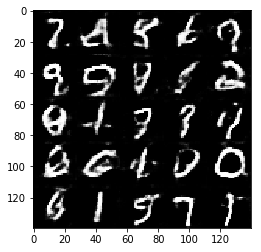

Epoch 1/2... Discriminator Loss: 1.3681... Generator Loss: 0.4135
Final of Epoch 1/2... Discriminator Loss: 1.0979... Generator Loss: 0.9946


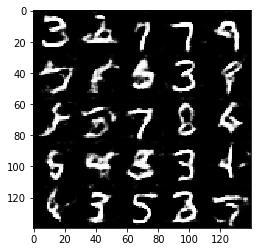

Epoch 2/2... Discriminator Loss: 1.0494... Generator Loss: 0.7505
Epoch 2/2... Discriminator Loss: 1.3043... Generator Loss: 0.4425
Epoch 2/2... Discriminator Loss: 1.3285... Generator Loss: 0.4595
Epoch 2/2... Discriminator Loss: 1.7680... Generator Loss: 1.6339
Epoch 2/2... Discriminator Loss: 1.0699... Generator Loss: 0.7027


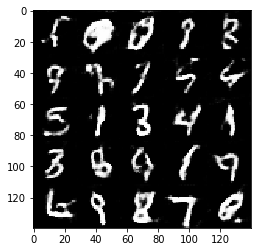

Epoch 2/2... Discriminator Loss: 1.4800... Generator Loss: 0.3488
Epoch 2/2... Discriminator Loss: 1.3057... Generator Loss: 1.2866
Epoch 2/2... Discriminator Loss: 1.1924... Generator Loss: 0.6034
Epoch 2/2... Discriminator Loss: 1.2812... Generator Loss: 1.5023
Epoch 2/2... Discriminator Loss: 1.3718... Generator Loss: 0.4052


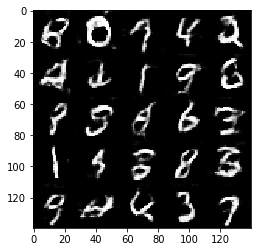

Epoch 2/2... Discriminator Loss: 1.6870... Generator Loss: 0.2957
Epoch 2/2... Discriminator Loss: 0.7682... Generator Loss: 1.2926
Epoch 2/2... Discriminator Loss: 0.9841... Generator Loss: 1.0761
Epoch 2/2... Discriminator Loss: 1.2835... Generator Loss: 0.5343
Epoch 2/2... Discriminator Loss: 1.8878... Generator Loss: 2.3501


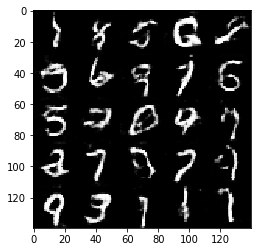

Epoch 2/2... Discriminator Loss: 0.9629... Generator Loss: 0.9880
Epoch 2/2... Discriminator Loss: 1.0736... Generator Loss: 0.5907
Epoch 2/2... Discriminator Loss: 1.3613... Generator Loss: 0.4219
Epoch 2/2... Discriminator Loss: 2.2184... Generator Loss: 0.1557
Epoch 2/2... Discriminator Loss: 1.0579... Generator Loss: 0.7557


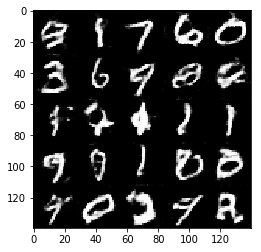

Epoch 2/2... Discriminator Loss: 1.4479... Generator Loss: 1.8104
Epoch 2/2... Discriminator Loss: 1.2435... Generator Loss: 0.4766
Epoch 2/2... Discriminator Loss: 0.9417... Generator Loss: 1.0941
Epoch 2/2... Discriminator Loss: 0.6992... Generator Loss: 1.1122
Epoch 2/2... Discriminator Loss: 0.8473... Generator Loss: 0.9205


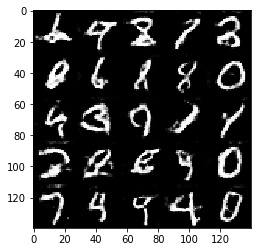

Epoch 2/2... Discriminator Loss: 1.8943... Generator Loss: 0.2013
Epoch 2/2... Discriminator Loss: 0.9221... Generator Loss: 0.8757
Epoch 2/2... Discriminator Loss: 1.3357... Generator Loss: 0.4047
Epoch 2/2... Discriminator Loss: 1.0767... Generator Loss: 0.5485
Epoch 2/2... Discriminator Loss: 1.2935... Generator Loss: 0.4606


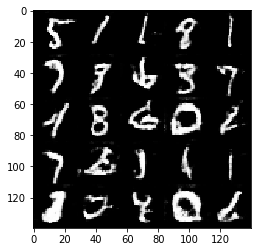

Epoch 2/2... Discriminator Loss: 1.0116... Generator Loss: 1.4556
Epoch 2/2... Discriminator Loss: 1.0514... Generator Loss: 0.6489
Epoch 2/2... Discriminator Loss: 0.9186... Generator Loss: 1.6549
Epoch 2/2... Discriminator Loss: 1.1350... Generator Loss: 0.5298
Epoch 2/2... Discriminator Loss: 1.0139... Generator Loss: 0.5921


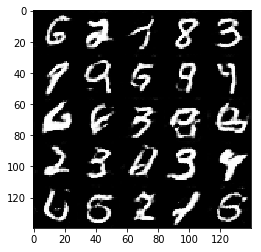

Epoch 2/2... Discriminator Loss: 1.0228... Generator Loss: 0.6243
Epoch 2/2... Discriminator Loss: 1.1775... Generator Loss: 0.5232
Epoch 2/2... Discriminator Loss: 1.0068... Generator Loss: 1.6864
Epoch 2/2... Discriminator Loss: 1.2262... Generator Loss: 0.4741
Epoch 2/2... Discriminator Loss: 0.9389... Generator Loss: 0.7275


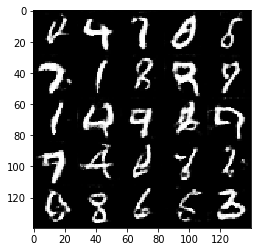

Epoch 2/2... Discriminator Loss: 1.0887... Generator Loss: 0.5440
Epoch 2/2... Discriminator Loss: 0.6256... Generator Loss: 1.3163
Epoch 2/2... Discriminator Loss: 1.8259... Generator Loss: 0.2761
Epoch 2/2... Discriminator Loss: 0.8258... Generator Loss: 1.1375
Epoch 2/2... Discriminator Loss: 1.1048... Generator Loss: 2.0394


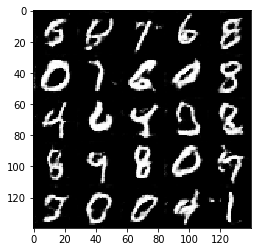

Epoch 2/2... Discriminator Loss: 0.8641... Generator Loss: 0.8465
Final of Epoch 2/2... Discriminator Loss: 0.6165... Generator Loss: 1.8248


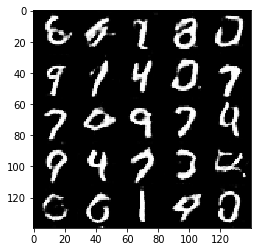

In [26]:
batch_size = 64
z_dim = 100
beta1 = 0.1
learning_rate = 0.0002

tf.reset_default_graph()


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.4778... Generator Loss: 5.7234
Epoch 1/1... Discriminator Loss: 2.2291... Generator Loss: 3.5330
Epoch 1/1... Discriminator Loss: 0.3829... Generator Loss: 2.8658
Epoch 1/1... Discriminator Loss: 1.5449... Generator Loss: 0.2847
Epoch 1/1... Discriminator Loss: 0.3757... Generator Loss: 1.5752


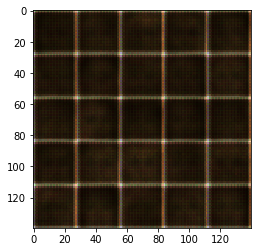

Epoch 1/1... Discriminator Loss: 2.4944... Generator Loss: 0.1056
Epoch 1/1... Discriminator Loss: 2.0605... Generator Loss: 0.1742
Epoch 1/1... Discriminator Loss: 0.8658... Generator Loss: 5.0664
Epoch 1/1... Discriminator Loss: 1.7897... Generator Loss: 4.4003
Epoch 1/1... Discriminator Loss: 2.5294... Generator Loss: 0.1051


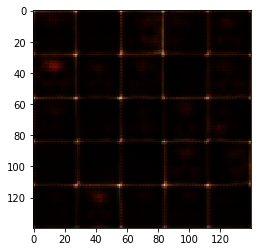

Epoch 1/1... Discriminator Loss: 0.8764... Generator Loss: 0.7163
Epoch 1/1... Discriminator Loss: 0.6958... Generator Loss: 3.0901
Epoch 1/1... Discriminator Loss: 0.6418... Generator Loss: 2.3797
Epoch 1/1... Discriminator Loss: 0.6323... Generator Loss: 1.0457
Epoch 1/1... Discriminator Loss: 0.9984... Generator Loss: 0.6892


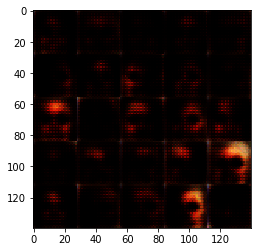

Epoch 1/1... Discriminator Loss: 1.7823... Generator Loss: 0.2584
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.3907
Epoch 1/1... Discriminator Loss: 0.3724... Generator Loss: 2.8026
Epoch 1/1... Discriminator Loss: 0.7103... Generator Loss: 1.5124
Epoch 1/1... Discriminator Loss: 0.7296... Generator Loss: 0.8740


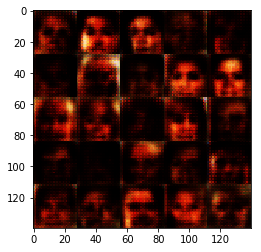

Epoch 1/1... Discriminator Loss: 1.5133... Generator Loss: 0.3128
Epoch 1/1... Discriminator Loss: 0.7321... Generator Loss: 0.9168
Epoch 1/1... Discriminator Loss: 1.3202... Generator Loss: 0.4324
Epoch 1/1... Discriminator Loss: 1.0385... Generator Loss: 2.0421
Epoch 1/1... Discriminator Loss: 1.2221... Generator Loss: 0.4254


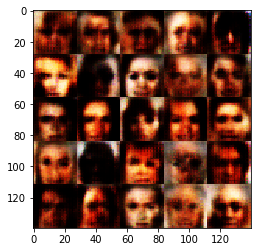

Epoch 1/1... Discriminator Loss: 1.0712... Generator Loss: 0.5339
Epoch 1/1... Discriminator Loss: 0.9925... Generator Loss: 1.4103
Epoch 1/1... Discriminator Loss: 0.6745... Generator Loss: 2.4946
Epoch 1/1... Discriminator Loss: 0.8112... Generator Loss: 1.1743
Epoch 1/1... Discriminator Loss: 1.3106... Generator Loss: 1.5074


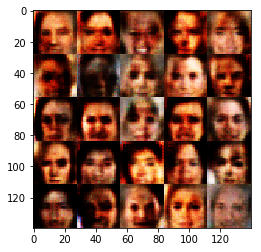

Epoch 1/1... Discriminator Loss: 1.2650... Generator Loss: 0.4231
Epoch 1/1... Discriminator Loss: 0.5479... Generator Loss: 2.3490
Epoch 1/1... Discriminator Loss: 0.6225... Generator Loss: 2.4000
Epoch 1/1... Discriminator Loss: 0.4531... Generator Loss: 1.7642
Epoch 1/1... Discriminator Loss: 0.6209... Generator Loss: 1.2705


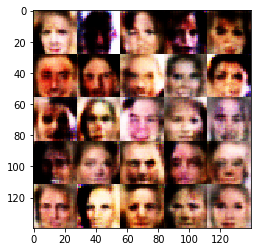

Epoch 1/1... Discriminator Loss: 0.7104... Generator Loss: 1.8695
Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 0.4701
Epoch 1/1... Discriminator Loss: 1.4444... Generator Loss: 1.7822
Epoch 1/1... Discriminator Loss: 0.9714... Generator Loss: 0.6008
Epoch 1/1... Discriminator Loss: 1.5705... Generator Loss: 3.0080


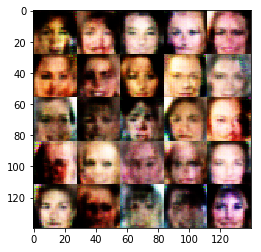

Epoch 1/1... Discriminator Loss: 1.3196... Generator Loss: 0.8896
Epoch 1/1... Discriminator Loss: 1.3020... Generator Loss: 0.3986
Epoch 1/1... Discriminator Loss: 0.7875... Generator Loss: 0.8732
Epoch 1/1... Discriminator Loss: 0.5479... Generator Loss: 1.5807
Epoch 1/1... Discriminator Loss: 1.7355... Generator Loss: 0.2643


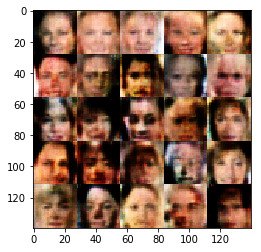

Epoch 1/1... Discriminator Loss: 2.5538... Generator Loss: 1.8583
Epoch 1/1... Discriminator Loss: 0.5349... Generator Loss: 2.2550
Epoch 1/1... Discriminator Loss: 0.8771... Generator Loss: 0.6551
Epoch 1/1... Discriminator Loss: 0.6320... Generator Loss: 1.8430
Epoch 1/1... Discriminator Loss: 0.4481... Generator Loss: 1.4319


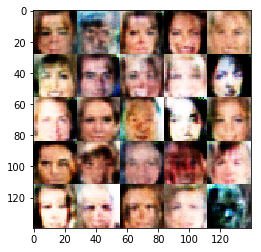

Epoch 1/1... Discriminator Loss: 0.9443... Generator Loss: 1.6067
Epoch 1/1... Discriminator Loss: 1.0978... Generator Loss: 0.8492
Epoch 1/1... Discriminator Loss: 0.7347... Generator Loss: 0.9733
Epoch 1/1... Discriminator Loss: 0.2948... Generator Loss: 2.1957
Epoch 1/1... Discriminator Loss: 1.1176... Generator Loss: 0.5154


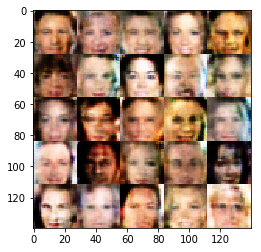

Epoch 1/1... Discriminator Loss: 0.3732... Generator Loss: 2.3373
Epoch 1/1... Discriminator Loss: 0.7674... Generator Loss: 1.0391
Epoch 1/1... Discriminator Loss: 1.7458... Generator Loss: 2.5904
Epoch 1/1... Discriminator Loss: 0.8174... Generator Loss: 0.8582
Epoch 1/1... Discriminator Loss: 1.2204... Generator Loss: 0.5238


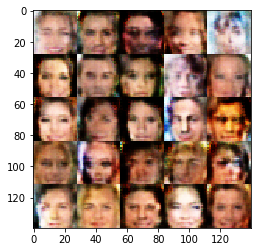

Epoch 1/1... Discriminator Loss: 1.4227... Generator Loss: 0.3385
Epoch 1/1... Discriminator Loss: 0.5358... Generator Loss: 4.0139
Epoch 1/1... Discriminator Loss: 0.6981... Generator Loss: 1.2664
Epoch 1/1... Discriminator Loss: 0.5131... Generator Loss: 1.2580
Epoch 1/1... Discriminator Loss: 0.3570... Generator Loss: 1.8924


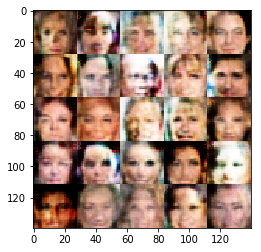

Epoch 1/1... Discriminator Loss: 1.2850... Generator Loss: 1.3084
Epoch 1/1... Discriminator Loss: 0.4969... Generator Loss: 1.3336
Epoch 1/1... Discriminator Loss: 1.2133... Generator Loss: 0.4226
Epoch 1/1... Discriminator Loss: 1.5068... Generator Loss: 0.3230
Epoch 1/1... Discriminator Loss: 0.5252... Generator Loss: 1.4198


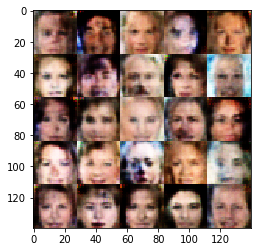

Epoch 1/1... Discriminator Loss: 1.0841... Generator Loss: 1.6732
Epoch 1/1... Discriminator Loss: 0.5763... Generator Loss: 1.6537
Epoch 1/1... Discriminator Loss: 1.5401... Generator Loss: 0.3155
Epoch 1/1... Discriminator Loss: 0.4729... Generator Loss: 1.7059
Epoch 1/1... Discriminator Loss: 1.6367... Generator Loss: 0.3116


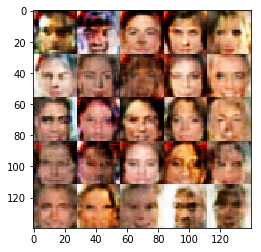

Epoch 1/1... Discriminator Loss: 0.9944... Generator Loss: 1.1485
Epoch 1/1... Discriminator Loss: 0.3369... Generator Loss: 2.2938
Epoch 1/1... Discriminator Loss: 1.4434... Generator Loss: 1.2689
Epoch 1/1... Discriminator Loss: 1.8389... Generator Loss: 1.2518
Epoch 1/1... Discriminator Loss: 1.4172... Generator Loss: 1.2039


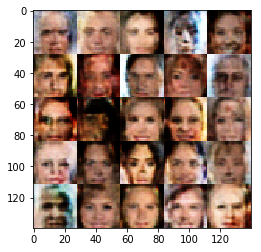

Epoch 1/1... Discriminator Loss: 0.7291... Generator Loss: 1.6703
Epoch 1/1... Discriminator Loss: 0.9222... Generator Loss: 0.6545
Epoch 1/1... Discriminator Loss: 1.1158... Generator Loss: 2.3655
Epoch 1/1... Discriminator Loss: 1.2303... Generator Loss: 0.6645
Epoch 1/1... Discriminator Loss: 0.5901... Generator Loss: 2.5590


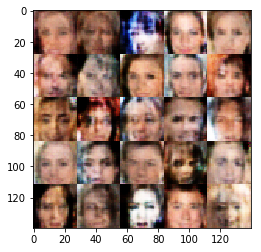

Epoch 1/1... Discriminator Loss: 0.8753... Generator Loss: 0.7228
Epoch 1/1... Discriminator Loss: 0.9168... Generator Loss: 0.6913
Epoch 1/1... Discriminator Loss: 1.0674... Generator Loss: 0.8794
Epoch 1/1... Discriminator Loss: 0.9256... Generator Loss: 0.7679
Epoch 1/1... Discriminator Loss: 0.9190... Generator Loss: 2.0577


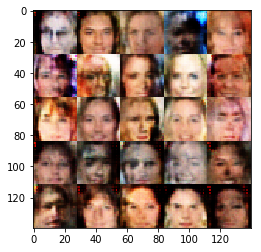

Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.3755
Epoch 1/1... Discriminator Loss: 1.5671... Generator Loss: 0.3300
Epoch 1/1... Discriminator Loss: 0.7615... Generator Loss: 0.9482
Epoch 1/1... Discriminator Loss: 1.1463... Generator Loss: 0.5675
Epoch 1/1... Discriminator Loss: 1.2546... Generator Loss: 0.6369


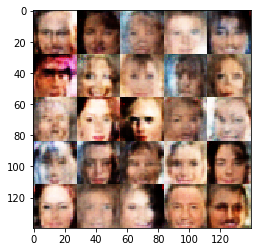

Epoch 1/1... Discriminator Loss: 1.1861... Generator Loss: 0.5190
Epoch 1/1... Discriminator Loss: 1.1082... Generator Loss: 1.2704
Epoch 1/1... Discriminator Loss: 0.5067... Generator Loss: 1.6830
Epoch 1/1... Discriminator Loss: 1.6645... Generator Loss: 0.2658
Epoch 1/1... Discriminator Loss: 1.1741... Generator Loss: 0.5844


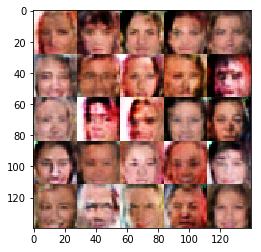

Epoch 1/1... Discriminator Loss: 0.4684... Generator Loss: 1.6854
Epoch 1/1... Discriminator Loss: 0.6864... Generator Loss: 1.7164
Epoch 1/1... Discriminator Loss: 0.5013... Generator Loss: 1.7518
Epoch 1/1... Discriminator Loss: 1.5580... Generator Loss: 0.3377
Epoch 1/1... Discriminator Loss: 0.9731... Generator Loss: 0.5538


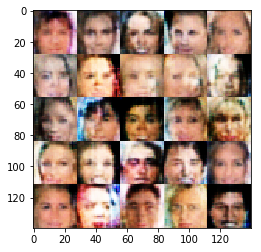

Epoch 1/1... Discriminator Loss: 0.4458... Generator Loss: 1.9267
Epoch 1/1... Discriminator Loss: 1.8184... Generator Loss: 1.9748
Epoch 1/1... Discriminator Loss: 0.3569... Generator Loss: 1.7733
Epoch 1/1... Discriminator Loss: 1.6789... Generator Loss: 0.2738
Epoch 1/1... Discriminator Loss: 1.2163... Generator Loss: 1.0295


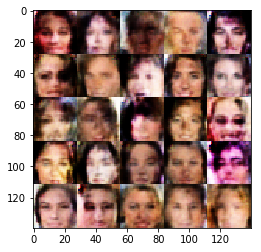

Epoch 1/1... Discriminator Loss: 1.0686... Generator Loss: 0.5944
Epoch 1/1... Discriminator Loss: 0.8532... Generator Loss: 0.9713
Epoch 1/1... Discriminator Loss: 0.7641... Generator Loss: 1.0999
Epoch 1/1... Discriminator Loss: 1.2398... Generator Loss: 0.8414
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.4496


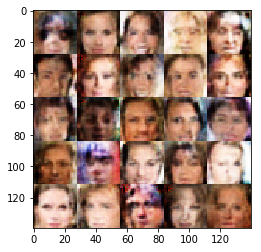

Epoch 1/1... Discriminator Loss: 1.8380... Generator Loss: 0.2081
Epoch 1/1... Discriminator Loss: 1.1082... Generator Loss: 0.4509
Epoch 1/1... Discriminator Loss: 0.6089... Generator Loss: 1.0667
Epoch 1/1... Discriminator Loss: 0.6583... Generator Loss: 0.9610
Epoch 1/1... Discriminator Loss: 1.2111... Generator Loss: 0.5076


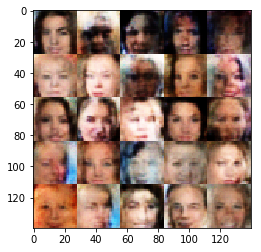

Epoch 1/1... Discriminator Loss: 0.9321... Generator Loss: 1.8849
Epoch 1/1... Discriminator Loss: 1.4499... Generator Loss: 0.6163
Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 2.3641
Epoch 1/1... Discriminator Loss: 1.5748... Generator Loss: 0.3600
Epoch 1/1... Discriminator Loss: 0.9333... Generator Loss: 0.6724


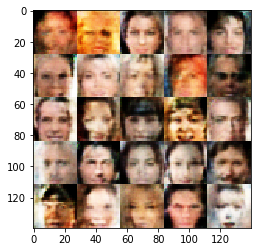

Epoch 1/1... Discriminator Loss: 0.7187... Generator Loss: 1.4830
Epoch 1/1... Discriminator Loss: 0.4952... Generator Loss: 1.5132
Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 2.3454
Epoch 1/1... Discriminator Loss: 0.3688... Generator Loss: 1.8401
Epoch 1/1... Discriminator Loss: 2.2377... Generator Loss: 2.2103


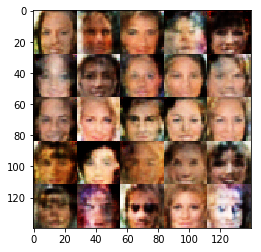

Epoch 1/1... Discriminator Loss: 0.7756... Generator Loss: 1.0425
Epoch 1/1... Discriminator Loss: 0.3759... Generator Loss: 1.8082
Epoch 1/1... Discriminator Loss: 1.0423... Generator Loss: 2.2477
Epoch 1/1... Discriminator Loss: 0.4923... Generator Loss: 1.7757
Epoch 1/1... Discriminator Loss: 0.9845... Generator Loss: 0.5886


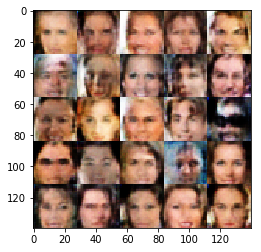

Epoch 1/1... Discriminator Loss: 1.3610... Generator Loss: 0.4932
Epoch 1/1... Discriminator Loss: 1.9100... Generator Loss: 1.8753
Epoch 1/1... Discriminator Loss: 1.5905... Generator Loss: 2.1170
Epoch 1/1... Discriminator Loss: 1.1740... Generator Loss: 2.0300
Epoch 1/1... Discriminator Loss: 0.5262... Generator Loss: 1.3914


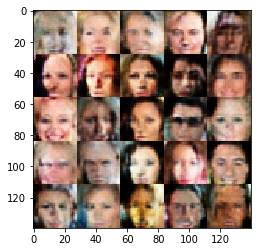

Epoch 1/1... Discriminator Loss: 2.0907... Generator Loss: 0.1754
Epoch 1/1... Discriminator Loss: 0.8755... Generator Loss: 1.0726
Epoch 1/1... Discriminator Loss: 0.4579... Generator Loss: 1.6149
Epoch 1/1... Discriminator Loss: 0.8888... Generator Loss: 2.9105
Epoch 1/1... Discriminator Loss: 0.7800... Generator Loss: 0.8430


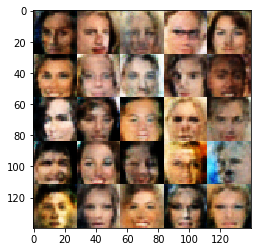

Epoch 1/1... Discriminator Loss: 0.7805... Generator Loss: 1.0481
Epoch 1/1... Discriminator Loss: 1.0884... Generator Loss: 1.6215
Epoch 1/1... Discriminator Loss: 0.9584... Generator Loss: 1.4017
Epoch 1/1... Discriminator Loss: 0.7751... Generator Loss: 2.6349
Epoch 1/1... Discriminator Loss: 2.1648... Generator Loss: 2.1220


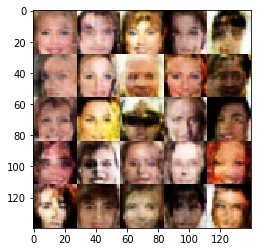

Epoch 1/1... Discriminator Loss: 1.1727... Generator Loss: 1.6871
Epoch 1/1... Discriminator Loss: 0.9960... Generator Loss: 1.6571
Epoch 1/1... Discriminator Loss: 0.5247... Generator Loss: 1.5286
Epoch 1/1... Discriminator Loss: 0.7293... Generator Loss: 1.5677
Epoch 1/1... Discriminator Loss: 0.6497... Generator Loss: 1.2727


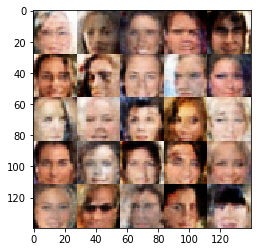

Epoch 1/1... Discriminator Loss: 0.9264... Generator Loss: 0.7128
Epoch 1/1... Discriminator Loss: 1.3238... Generator Loss: 0.4277
Epoch 1/1... Discriminator Loss: 1.0715... Generator Loss: 0.8049
Final of Epoch 1/1... Discriminator Loss: 0.7932... Generator Loss: 1.6666


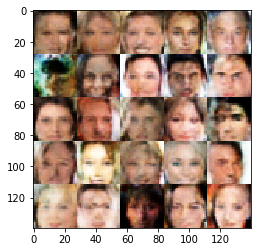

In [27]:
z_dim = 100
batch_size = 64
beta1 = 0.1
learning_rate = 0.0002

tf.reset_default_graph()


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.